In [1]:
import arfs
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import arfs.feature_selection as arfsfs
from arfs.feature_selection import GrootCV
from ydata_profiling import ProfileReport
from lightgbm import LGBMClassifier
from sklearn.base import clone
rng = np.random.RandomState(seed=42)

In [12]:
cont_cols = [
    # General
    # 'D_Date',  # Date
    'D_datediff',  # Date
    
    # Random
    'D_AB',   # At Bats
    'D_R',    # Runs
    'D_H',    # Hits
    'D_BB',   # Walks
    'D_PA',   # Plate Appearances
    
    # Batting stats
    'D_SO',    # Strikeouts
    'D_BA',    # Batting Average
    'D_OBP',   # On-Base Percentage
    'D_SLG',   # Slugging Percentage
    'D_OPS',   # On-Base Plus Slugging
    'D_RBI',   # Runs Batted In
    'D_PIT',   # Pitches
    'D_STR',   # Strikes
    'D_WPA',   # Win Probability Added
    'D_aLI',   # Average Leverage Index

    # Pitching stats
    'D_P_H',   # Hits Allowed by Pitcher
    'D_P_R',   # Runs Allowed by Pitcher
    'D_ER',    # Earned Runs by Pitcher
    'D_P_BB',  # Walks by Pitcher
    'D_P_SO',  # Strikeouts by Pitcher
    'D_HR',    # Home Runs Allowed by Pitcher
    'D_ERA',   # Earned Run Average
    'D_CTCT',  # Contact Rate
    'D_STS',   # Swings and Misses (Strikes)
    'D_STL',   # Stolen Bases Against
    'D_GB',    # Ground Balls
    'D_FB',    # Fly Balls
    'D_LD',    # Line Drives
    'D_GSC',   # Game Score
    'D_P_WPA', # Pitcher Win Probability Added
    'D_P_aLI', # Pitcher Average Leverage Index

    # Odds
    'D_start_odds',

    # Calculated
    'D_pythagorean',
    
    # Remove later
    # 'D_Final_Score',
    # 'D_Final_Allowed'
]


In [3]:
df = pd.read_csv("./baseballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32055 entries, 0 to 32054
Data columns (total 68 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            32055 non-null  int64  
 1   Date                  32055 non-null  object 
 2   Home_Team             32055 non-null  object 
 3   Home_Wins             32055 non-null  int64  
 4   Home_Losses           32055 non-null  int64  
 5   Visitor_Team          32055 non-null  object 
 6   Visitor_Wins          32055 non-null  int64  
 7   Visitor_Losses        32055 non-null  int64  
 8   Final_Score           32055 non-null  object 
 9   Visitor_Final_Score   32055 non-null  int64  
 10  Home_Final_Score      32055 non-null  int64  
 11  Winning_Team          32055 non-null  object 
 12  Home/Victory_Win      32055 non-null  object 
 13  Game_Time             32055 non-null  object 
 14  Winning_Pitcher       32055 non-null  object 
 15  Visiting_Pitcher   

In [4]:
# Removing the following (judged by previous runs of this file)
drop_cols = [ 'D_BA', 'D_datediff', 'D_AB', 'D_P_WPA', 'D_P_H', 'D_ER', 'D_BA', 'D_ERA', 'D_SLG', 'D_H', 'D_STR' ]

y = df['H_Won']
cont_cols_drop = [col for col in cont_cols if col not in drop_cols]
df = df[cont_cols_drop]

In [5]:
profile = ProfileReport(df, title="Profiling Report")

# Configuration
profile.config.vars.num.skewness_threshold = 1

# Save profile to file

In [6]:
# profile.to_widgets()
# profile.to_file("MLBEdaReportOne.html")

# ARFS and feature selection
[you'll need at least python 3.9 for this](https://github.com/ThomasBury/arfs/issues/29) 

In [7]:
X = df
print(X.shape)
print(y.shape)

(32055, 24)
(32055,)


In [8]:
import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
from arfs.utils import LightForestClassifier, LightForestRegressor
from arfs.benchmark import highlight_tick, compare_varimp, sklearn_pimp_bench
from arfs.utils import load_data
from sklearn.pipeline import Pipeline

/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/arfs/feature_selection/allrelevant.py:1578: UserWarning: fasttreeshap is not installed. Fallback to shap.
  warnings.warn("fasttreeshap is not installed. Fallback to shap.")


BoostaGRoota round:   0%|          | 0/10 [00:00<?, ?it/s]

The selected features: ['D_P_BB' 'D_FB' 'D_start_odds' 'D_pythagorean']
The agnostic ranking: [1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 2]
The naive ranking: ['D_pythagorean', 'D_start_odds', 'D_FB', 'D_P_BB', 'D_STS', 'D_OPS', 'D_P_SO', 'D_STL', 'D_LD', 'D_P_R', 'D_OBP', 'D_PA', 'D_WPA', 'D_aLI', 'D_BB', 'D_PIT', 'D_HR', 'D_GB', 'D_CTCT', 'D_GSC', 'D_SO', 'D_P_aLI', 'D_RBI', 'D_R']


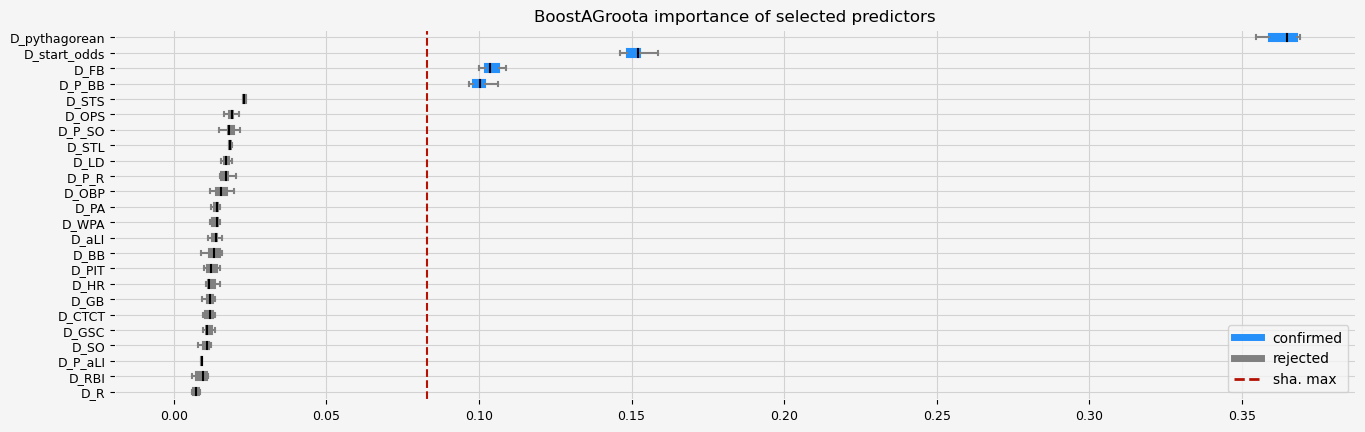

In [9]:
# be sure to use the same but non-fitted estimator
model = LGBMClassifier(random_state=42, verbose=-1)
# BoostAGroota
feat_selector = arfsgroot.BoostAGroota(
    estimator=model,
    cutoff=1,
    iters=10,
    max_rounds=10,
    delta=0.1,
    silent=True,
    importance="fastshap",
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# Leshy

Leshy iteration:   0%|          | 0/10 [00:00<?, ?it/s]



Leshy finished running using native var. imp.

Iteration: 	1 / 10
Confirmed: 	3
Tentative: 	1
Rejected: 	20
All relevant predictors selected in 00:00:01.57
The selected features: ['D_P_BB' 'D_start_odds' 'D_pythagorean']
The agnostic ranking: [20  8 21 16 16 12 22 14 10  4  7  1  3 12 18  6  4 10  2  8 16 18  1  1]
The naive ranking: ['D_pythagorean', 'D_start_odds', 'D_P_BB', 'D_FB', 'D_aLI', 'D_P_SO', 'D_STS', 'D_STL', 'D_LD', 'D_P_R', 'D_BB', 'D_GB', 'D_PIT', 'D_OPS', 'D_HR', 'D_SO', 'D_GSC', 'D_WPA', 'D_P_aLI', 'D_CTCT', 'D_R', 'D_OBP', 'D_RBI', 'D_PA']


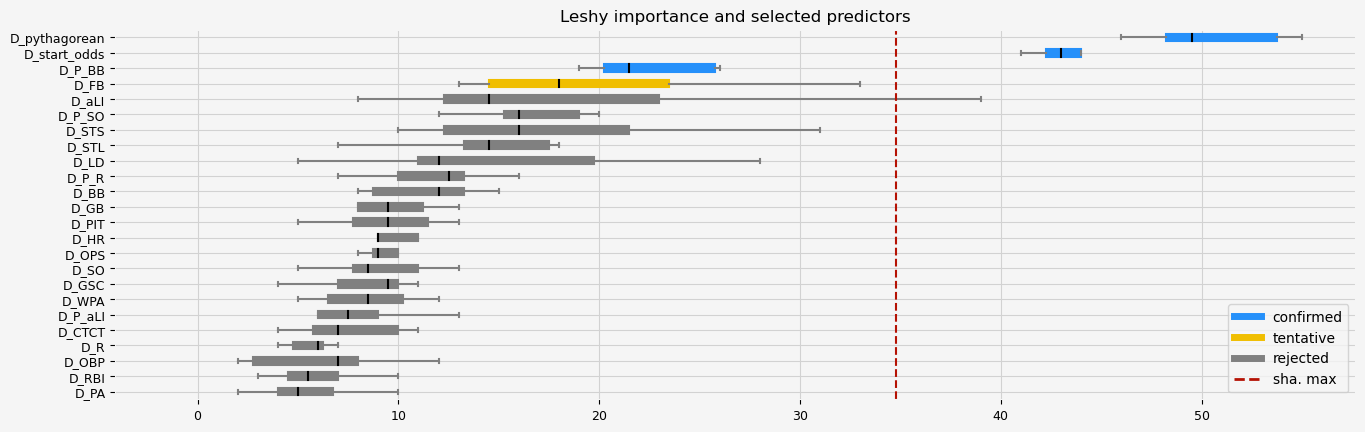

In [10]:
model = LGBMClassifier(random_state=42, verbose=-1)
feat_selector = arfsgroot.Leshy(
    model, n_estimators=20, verbose=1, max_iter=10, random_state=42, importance="native"
)
feat_selector.fit(X, y, sample_weight=None)
print(f"The selected features: {feat_selector.get_feature_names_out()}")
print(f"The agnostic ranking: {feat_selector.ranking_}")
print(f"The naive ranking: {feat_selector.ranking_absolutes_}")
fig = feat_selector.plot_importance(n_feat_per_inch=5)

# highlight synthetic random variable
fig = highlight_tick(figure=fig, str_match="random")
fig = highlight_tick(figure=fig, str_match="genuine", color="green")
plt.show()

# Removing the following
drop_cols = [ 'D_BA', 'D_datediff', 'D_AB', 'D_P_WPA', 'D_P_H', 'D_ER', 'D_BA', 'D_ERA', 'D_SLG', 'D_H', 'D_STR' ]
